# Sensitivity Analysis: 


"A fragile inference is not worth taking seriously." - Edward E. Leamer, 1985


Sensitivity analysis quantifies the degree to which a model input effects an output. So, even if we are given an optimization, machine learning, and any simulation black box process, we can assess which inputs are most important for the outputs. Generally these approaches are splitted into two different groups. We have local approaches and global approaches. For example, if we make a simple spreadsheet financial model, we probably use a local approach to examine how the interest rate affects our the net present value of an investment and we do it just by increasing or decresing it to see if it is important and then compare it to another input. So it is a local approach. A global approach starts varying all of the inputs to the model at the same time and tries to explore the global input space of the model and quantify the effects of that upon the output in a rigrous and a structured way. And these are the approaches that are mostly used in this task for trained model on one of the scenarios of the PROMIOOC project.

We can obtain three main sort of settings from a sensitivity analysis:

* Factor Prioritization
    - Which inputs are most important?
    - Focus development on which inputs
    - Identify fragility
* Factor Fixing
    - Which inputs can we safely ignore?
    - Reduce dimensionality
    - Identify redundancy (model and data)
    - Simplify models (factor affect model structure)
* Factor Mapping
    - Maps portion of output space onto inputs to say which inputs are most important for a specific portion of output
    - Threshold effects
    - Uniqueness, instability, runaway
    - Robustness

So, the steps are as follows:

1- Given our model, we define a dictionary of parameters this service defines our inputs and the ranges that we assign to the inputs.

2- We then generate a sample and this is a structured sample depending on which approach we are going to use.

3- And then we put this sample through the model and run the model.

4- Given the inputs to the model and the outputs from the model we can compute some sensitivity indices (result matrix)

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## TO DO
## 1. Determining the Appropriate Number of Samples for Sensitivity Analysis

In [ ]:
# Install SALib and bokeh libraries
! pip install SALib
! pip install bokeh
! pip install networkx
! pip install ipynb

     |████████████████████████████████| 860kB 2.7MB/s 
  Created wheel for SALib: filename=SALib-1.3.11-py2.py3-none-any.whl size=729665 sha256=f67974ee7f25a5da29ca9049cbdac24dc95e50092df58d587485a63a6fee8c2d
  Stored in directory: /root/.cache/pip/wheels/62/ed/f9/a0b98754ffb2191b98324b96cbbeb1bd5d9598b39ab996b429
Successfully built SALib


In [ ]:
# Mount google drive 
from google.colab import drive
drive.mount('/content/drive')
data_path = "/content/drive/My Drive/TATA/data"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Import needed libraries
import sys
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
import seaborn as sns

from SALib.sample import saltelli, morris, finite_diff, fast_sampler, latin
from SALib.sample.morris import sample as sample_morris
from SALib.plotting.bar import plot as barplot
from SALib.analyze import morris, sobol, dgsm, fast, delta, rbd_fast
from SALib.plotting.morris import horizontal_bar_plot, covariance_plot, sample_histograms


import networkx as nx
import itertools

In [ ]:
# Read files and data
feature_labels = np.load(os.path.join(data_path, "featurelabels_v7.npy"), fix_imports=True, encoding='latin1')[1:]
clf = keras.models.load_model(os.path.join(data_path, 'dnn_v1_hgroup_2.h5'))
realnames = np.load(os.path.join(data_path, "featurelabels_real.npy"),allow_pickle = True, fix_imports=True,encoding='latin1').item()

In [ ]:
# Clean feature_labels
feature_labels_new = []

for f in feature_labels:
    f = f.decode('utf-8')
    if (f in realnames.keys()):
        rn = realnames[f].replace(" ", "_")
        feature_labels_new.append(rn)
    else:
        feature_labels_new.append(f.replace(" ", "_"))

## 2. Method of Morris

### Principle of Method of Morris

The method of Morris is considered as a screening method. Screening methods have the following characteristics:

* They are computationally cheap and usually require a small number of model evaluatuions.
* They are conceived to deal with models containing tens or hundreds of input parameters efficiently.
* They provide a list of parameters ranked in order of decreasing importance, allowing the modeller to identify the subset of less influential ones (Factor Fixing).
* In general, screening designs perform better when the number of
important parameters in the model is small compared with the total
number of parameters.

The Morris method does not rely on restricted assumptions and is
therefore model independent. This method is known as a "One at a time" method, where only one parameter is changed at each simulation. Each input parameter may assume
a discrete number of values, called levels, which are chosen within
the paramter range of variation.

The variation of the objective function $F$ in relation to a parameter $X_i$ is calculated by finite difference between two sets of identical parameters with the exception of a single parameter. Thus, if there are $d$ parameters, we need $d+1$ simulations to assess the effect of a variation in each of them, i.e. $\frac{\Delta F}{\Delta X_1}, \frac{\Delta F}{\Delta X_2}, ..., \frac{\Delta F}{\Delta X_d}$.

In order to calculate an average elementary effect $\frac{\Delta F}{\Delta X_i}$, we generate $d+1$ parameter sets and repeat the operation a number of times $r$ (sample size). These are called "repetitions". 

The series of elementary effects is then processed $\frac{\Delta F}{\Delta X_i}$ of each parameter in order to calculate an **average elementary effect** $\mu_{i}$	(that estimates the overall effect of the parameter on the output) and a **standard deviation** $\sigma_i$ (that estimates the ensemble of the second- and higher-order effects in which the parameter is involved (including curvatures and interaction effects)). For the record, more the standard deviation of a series is large, the more the values are scattered around the average.

Here we use $\mu*$ which is a revised version of the Morris $\mu$. $\mu*$ is the average of the distribution of the absolute values of the elementary effects. $\mu*$ is very successful in ranking parameters in order of importance
and performs capably when the setting is that of Factor’s Fixing. $\mu*$ is used to detect input parameters with an important overall
influence on the output. $\sigma$ is used to detect parameters involved in
interaction with other parameters or whose effect is non-linear.

The classification of the parameters is then done according to the graph $(\mu, \sigma)$. Influential parameters have a high average elementary effect: a variation in the parameter will result in a significant variation in the objective function. If the standard deviation of the series of elementary effects is small, the effect is considered linear. If this standard deviation is large, especially if it is of the order of magnitude of the elementary effect (i. e. greater than or equal to the first bisector), the effect is non-linear or causes interactions with other parameters.

![picture](https://lhypercube.arep.fr/wp-content/uploads/2019/06/classement_effets_FP_EN-768x587.jpg)

The mean of the distribution $\mu$, which comes out at no extra
computational cost, can still be used to detect additional information on the signs of the effects that the parameter has on the output.
If the mean of $\mu$ is high, it implies not only that the parameter has
a large effect on the output but also that the sign of this effect is
always the same. If, in contrast, the mean of $\mu$ is low, while the
mean of $\mu*$ is high, it means that the parameter examined has effects of
different signs depending on the point in space at which the effect
is computed.

An intuitive interpretation of $\sigma$ is the following. Assume that, for parameter $X_i$ , we get a high value of $\sigma$. This means that the elementary effects relative to this parameter are significantly different from each other, i.e. the value of an elementary effect is strongly affected by the choice of the point in the input space at which it is computed, i.e. by the choice of the other parameter’s values. In contrast, a low $\sigma$ indicates very similar values of the elementary effects, implying that the effect of $X_i$ is almost independent of the values taken by the other parameters.

When the goal is to rank parameters in order of importance by making use of a single sensitivity measure, our advice is to use $\mu*$, which by making use of the absolute value, avoids the occurrence of effects of opposite signs.



In [ ]:
# Dictionary of paramters and their range
num_vars = len(feature_labels_new)

problem = {
  'num_vars': num_vars,
  'names': list(feature_labels_new),
  'bounds': [[0.0, 1.0]] * num_vars #standard scaled
}

In [ ]:
# Generate Morris samples
param_values = sample_morris(problem, N=100, num_levels=4, optimal_trajectories=None)

Returns a NumPy matrix containing the model inputs required for Method of
Morris. The resulting matrix has `(G+1)*T` rows and `D` columns, where `D` is the number of parameters, `G` is the number of groups (if no groups are selected, the number of parameters). `T` is the number of trajectories `N`, or `optimal_trajectories` if selected.

In [ ]:
# Making prediction
Y = clf.predict(param_values)
Y = np.nan_to_num(Y).flatten()

In [ ]:
# Perform Morris analysis on the model outputs
si_morris = morris.analyze(problem, param_values, Y, conf_level=0.95, 
                           print_to_console=False, num_levels=4, num_resamples=100)

In [ ]:
si_morris.keys()

dict_keys(['names', 'mu', 'mu_star', 'sigma', 'mu_star_conf'])

In [ ]:
def sort_si(si, key, sortby='vi'):
    return np.array([si[key][x] for x in np.argsort(si[sortby])])

def sort_index_by_index(si, key, index):
    return np.array([si[key][x] for x in index])

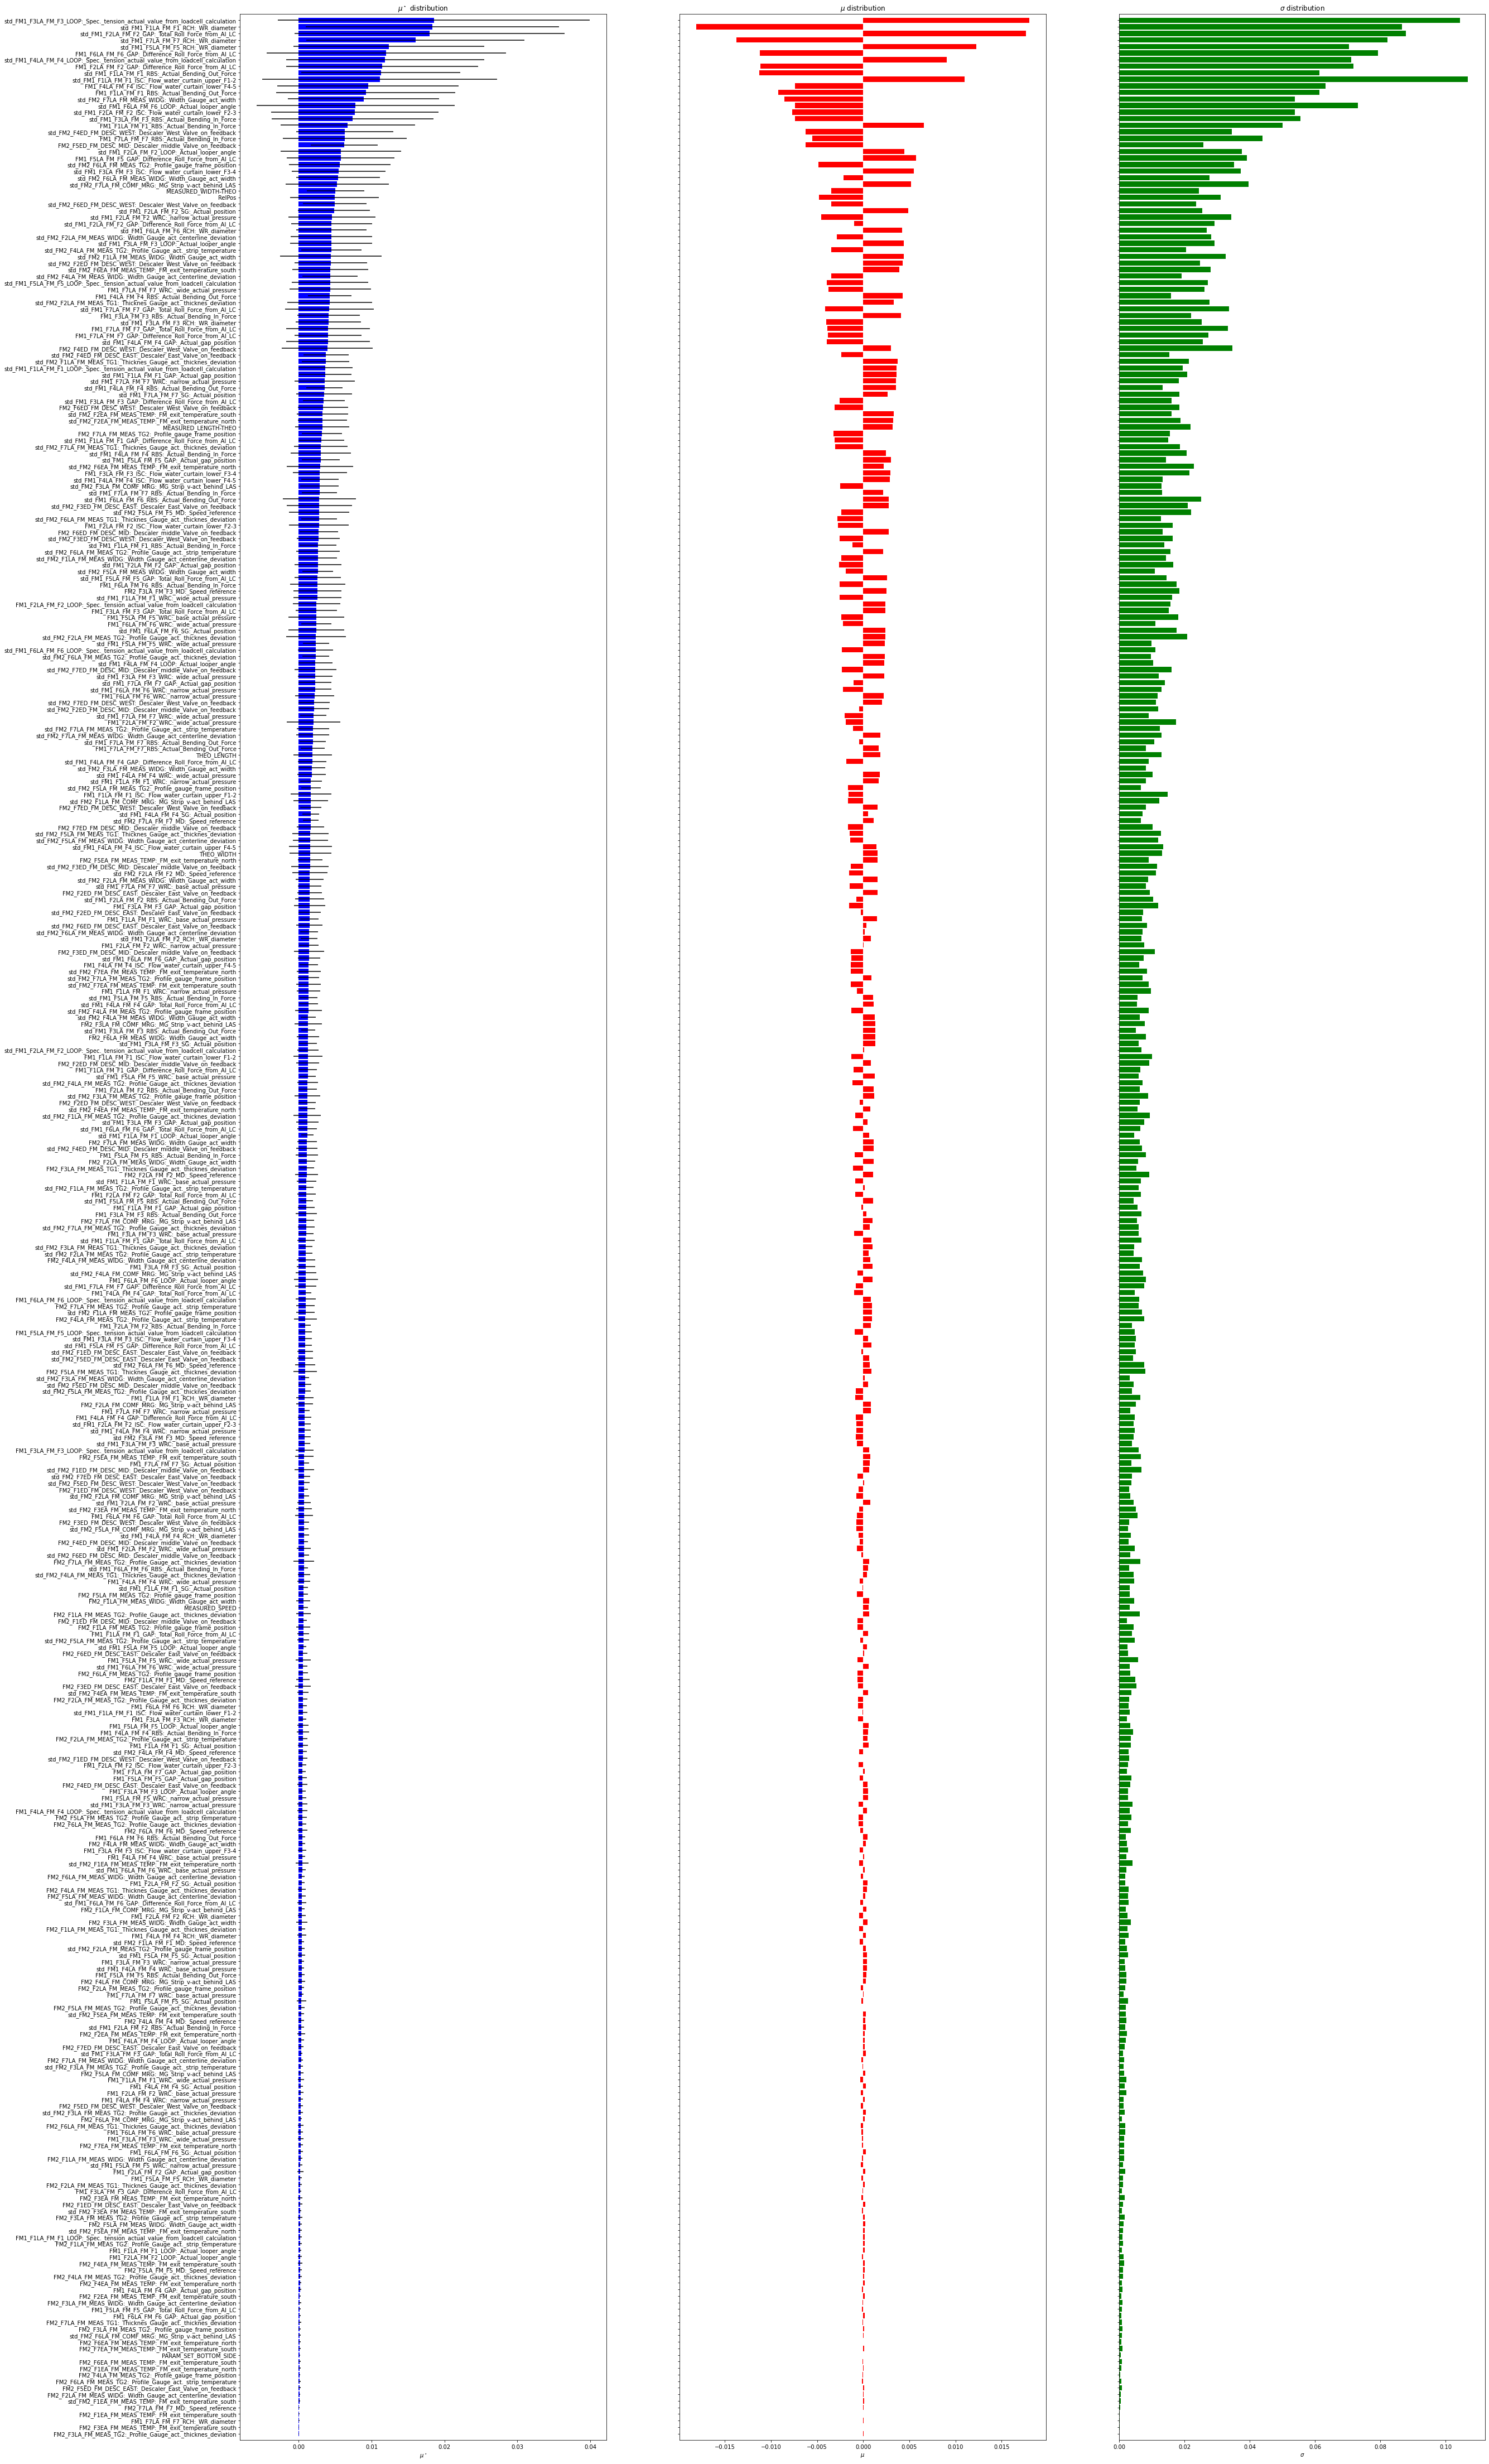

In [ ]:
# Sort all the plotted elements by mu_star (or optionally another metric)
names_sorted = sort_si(si_morris, 'names', sortby='mu_star')
mu_star_sorted = sort_si(si_morris, 'mu_star', sortby='mu_star')
mu_star_conf_sorted = sort_si(si_morris, 'mu_star_conf', sortby='mu_star')
mu_sorted = sort_si(si_morris, 'mu', sortby='mu_star')
sigma_sorted = sort_si(si_morris, 'sigma', sortby='mu_star')

# Plot horizontal barchart
y_pos = np.arange(len(names_sorted))
plot_names = names_sorted

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40, 80), sharey=True)

ax1.barh(y_pos,
         mu_star_sorted,
         xerr=mu_star_conf_sorted,
         align='center',
         ecolor='black',
         color='blue')

ax2.barh(y_pos,
         mu_sorted,
         align='center',
         ecolor='black',
         color='red')

ax3.barh(y_pos,
         sigma_sorted,
         align='center',
         ecolor='black',
         color='green')

# plot mu_star distribution
ax1.set_yticks(y_pos)
ax1.set_yticklabels(plot_names)
ax1.set_xlabel(r'$\mu^\star$')
ax1.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax1.set_title('$\mu^\star$ distribution')

# plot mu distribution
ax2.set_xlabel(r'$\mu$')
ax2.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax2.set_title('$\mu$ distribution')

# plot sigma distribution
ax3.set_xlabel(r'$\sigma$')
ax3.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax3.set_title('$\sigma$ distribution')

plt.show()

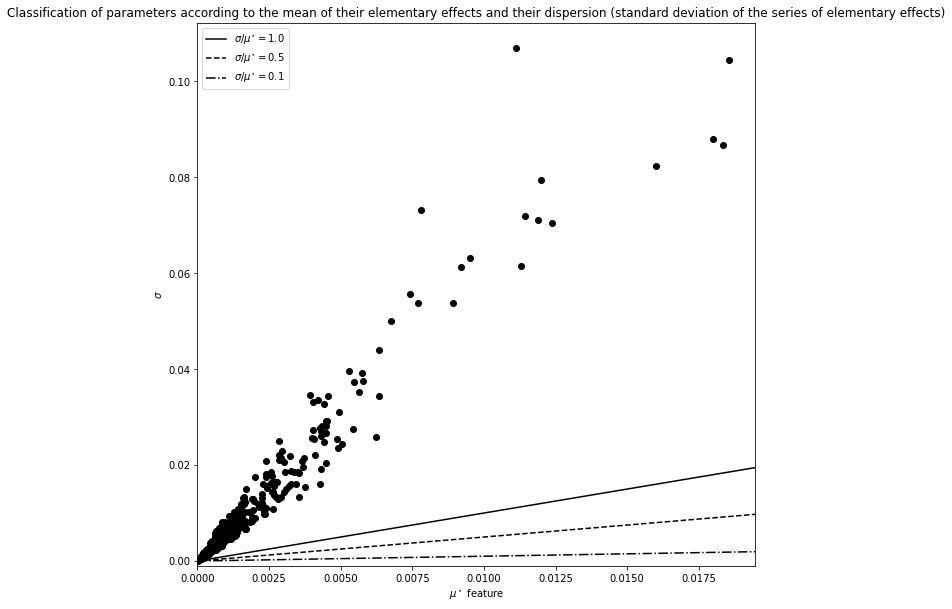

In [ ]:
fig, ax = plt.subplots(1, 1,figsize=(10, 10))
covariance_plot(ax, si_morris, unit=r"feature", param_dict={})
ax.set_title('Classification of parameters according to the mean of their elementary effects and their dispersion (standard deviation of the series of elementary effects)')
plt.show()

In [ ]:
names_sorted = sort_si(si_morris, 'names', sortby='sigma')[::-1]
mu_star_sorted = sort_si(si_morris, 'mu_star', sortby='sigma')[::-1]
sigma_sorted = sort_si(si_morris, 'sigma', sortby='sigma')[::-1]

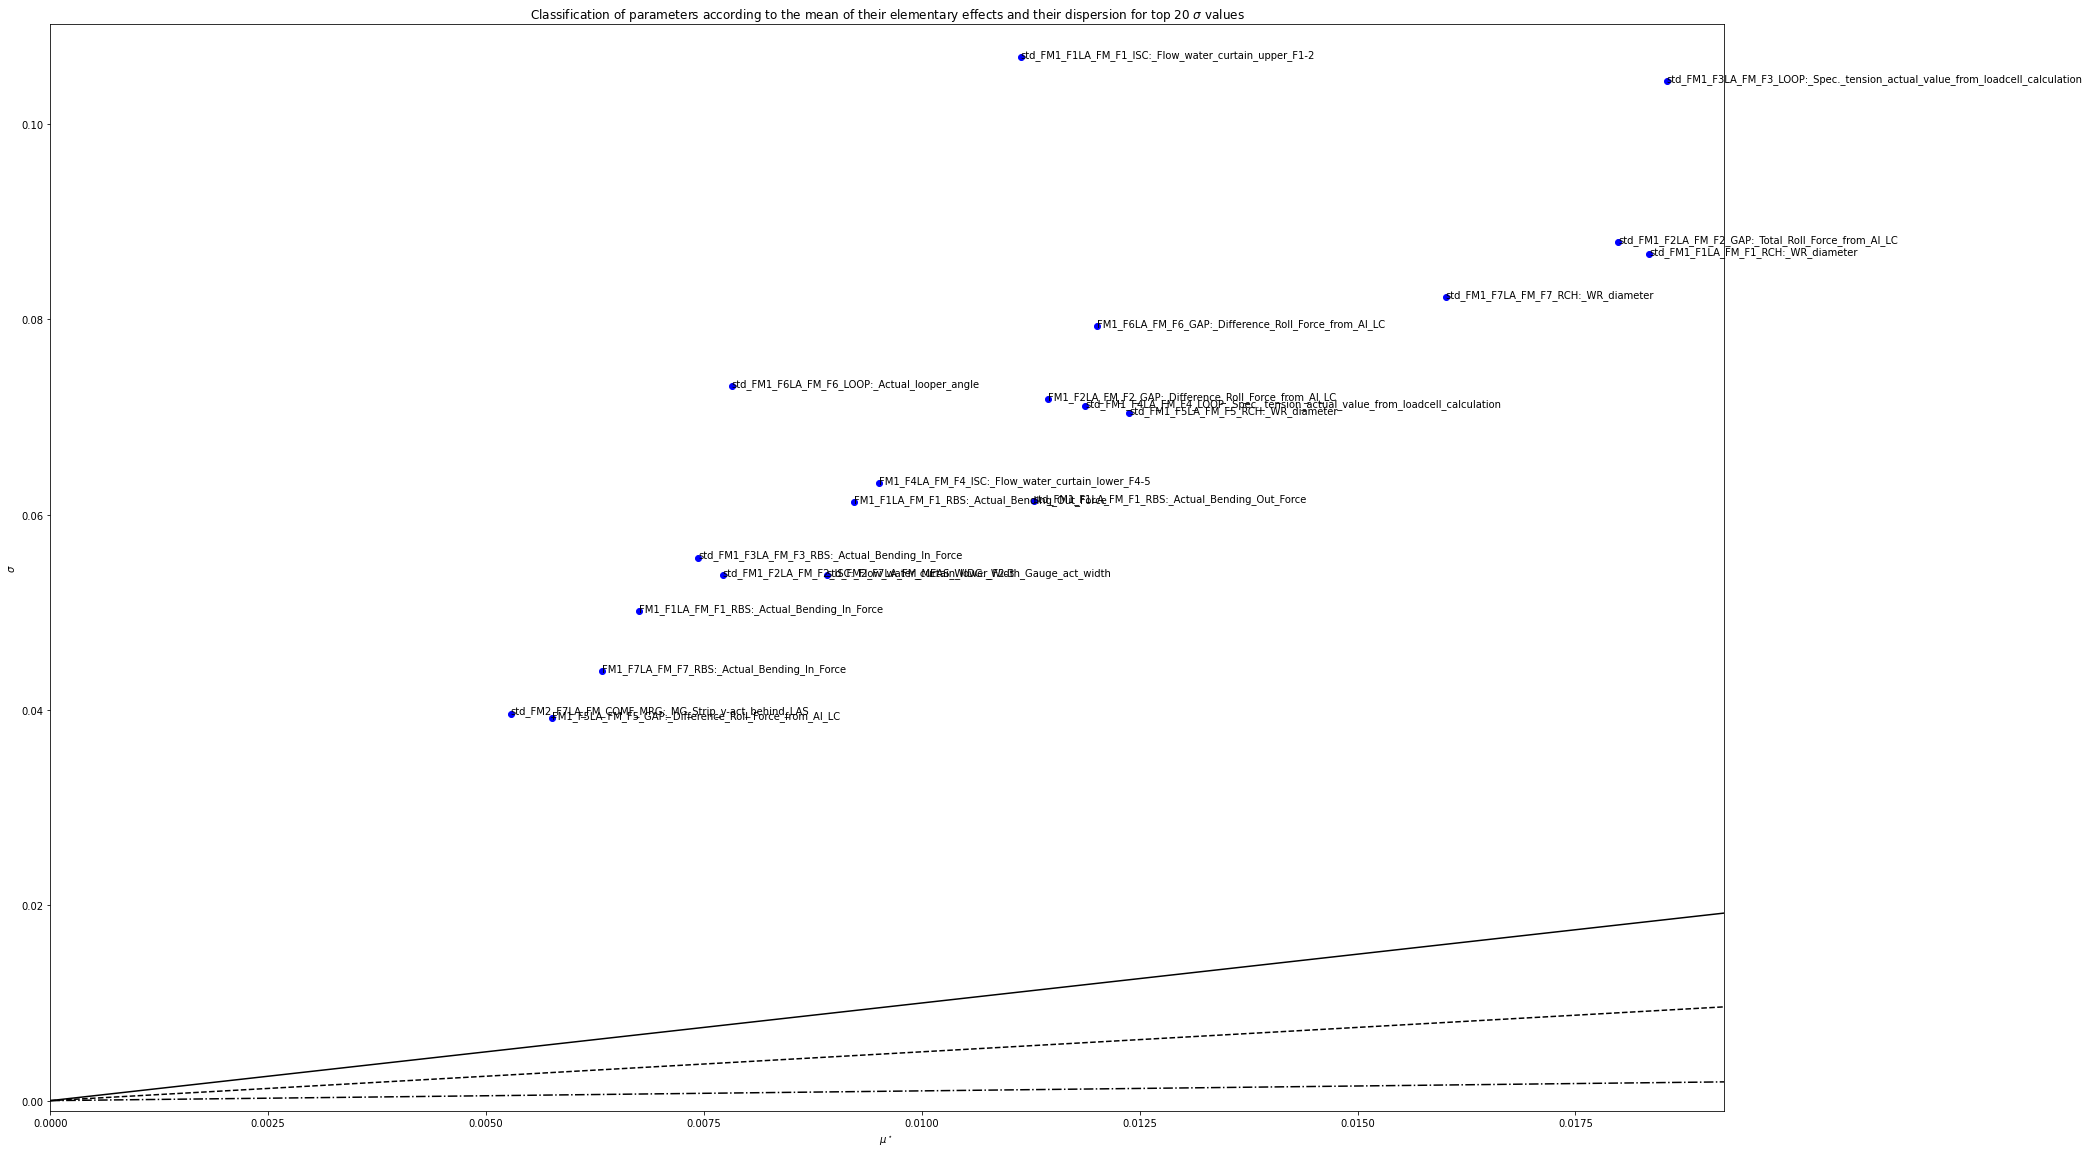

In [ ]:
# scatter plot of features with top 30 sigma values
y = sigma_sorted[:20]
x = mu_star_sorted[:20]
names = names_sorted[:20]

fig, ax = plt.subplots(1, 1, figsize=(30, 20))

ax.scatter(x, y, c=u'b', marker=u'o')
ax.set_ylabel(r'$\sigma$')
ax.set_xlim(0,)
ax.set_ylim(0,)

x_axis_bounds = np.array(ax.get_xlim())

line1 = ax.plot(x_axis_bounds, x_axis_bounds, 'k-')
line2 = ax.plot(x_axis_bounds, 0.5 * x_axis_bounds, 'k--')
line3 = ax.plot(x_axis_bounds, 0.1 * x_axis_bounds, 'k-.')

# ax.legend((line1, line2, line3), (r'$\sigma / \mu^{\star} = 1.0$',
#                                   r'$\sigma / \mu^{\star} = 0.5$',
#                                   r'$\sigma / \mu^{\star} = 0.1$'),
#                                   loc='best')

for i, txt in enumerate(names):
    ax.annotate(txt, (x[i], y[i]))

unit=''
ax.set_xlabel(r'$\mu^\star$ ' + unit)
ax.set_ylim(0-(0.01 * np.array(ax.get_ylim()[1])), )

ax.set_title('Classification of parameters according to the mean of their elementary effects and their dispersion for top 20 $\sigma$ values')

plt.show()

# 3. Sobol Sensitivity Analysis

Sobol's method is based on decomposition of the model output variance into summands of variances of the input parameters in increasing dimensionality. Sobol sensitivity analysis determines the contribution of each input parameter and their interactions to the overall model output variance.

Sobol sensitivity analysis is intended to determine how much of the variability in model output is dependent upon each of the input parameters, either upon a single parameter or upon an interaction between different parameters. The decomposition of the output variance in a Sobol sensitivity analysis employs the same principal as the classical analysis of variance in a factorial design. It should be noted that Sobol sensitivity analysis is not intended to identify the cause of the input variability. It just indicates what impact and to what extent it will have on model output. As a consequence, it cannot be used to determine the source(s) of variance.

Sobol sensitivity analysis has several features listed as the following:

* No assumption between model input and output
* Evaluation of the full range of each input parameter variation and interactions between parameters
* High computation intensity being the main drawback

There are important steps of Sobol sensitivity analysis. First, a parameter sequence is generated using Sobol sequence. Sobol sequence is a quasirandomized, low‐discrepancy sequence. Low‐discrepancy sequences typically sample space more uniformly than completely random sequences. Algorithms which use such sequences may have superior convergence. The generated parameter sets are subsequently used to simulate the model outputs.

In order to understand how the output variance be attributed to individual input variables and the interaction between each of the input variables, the total‐order $(ST)$, first‐order $(S1)$, second‐order $(S2)$, and higher‐order sensitivity indices are calculated to accurately reflect the influence of the individual input, and the interaction between them.

The Sobol sensitivity indices have several features, which can be categorized as following:
* The total‐/first‐/second‐order sensitivity indices are positive values.
* Parameters with sensitivity indices greater than 0.05 are considered significant.
* The sum of all the sensitivity indices should be equal to 1.
* The total‐order sensitivity indices are greater than the first‐order sensitivity indices.





In [ ]:
# Generate Sobol samples
param_values = saltelli.sample(problem, 100, calc_second_order=True)

In [ ]:
# Making prediction
Y = clf.predict(param_values)
Y = np.nan_to_num(Y).flatten()

In [ ]:
# Perform Sobol analysis on the model outputs
si_sobol = sobol.analyze(problem, Y, print_to_console=False)

In [ ]:
si_sobol_dict = {}
si_sobol_dict['names'] = problem['names']
si_sobol_dict['S1'] = si_sobol['S1']
si_sobol_dict['S1_conf'] = si_sobol['S1_conf']
si_sobol_dict['ST'] = si_sobol['ST']
si_sobol_dict['ST_conf'] = si_sobol['ST_conf']

In [ ]:
# Sort all the plotted elements by mu_star (or optionally another metric)
names_sorted = sort_si(si_sobol_dict, 'names', sortby='ST')
s1_sorted = sort_si(si_sobol_dict, 'S1', sortby='ST')
s1_conf_sorted = sort_si(si_sobol_dict, 'S1_conf', sortby='ST')
st_sorted = sort_si(si_sobol_dict, 'ST', sortby='ST')
st_conf_sorted = sort_si(si_sobol_dict, 'ST_conf', sortby='ST')

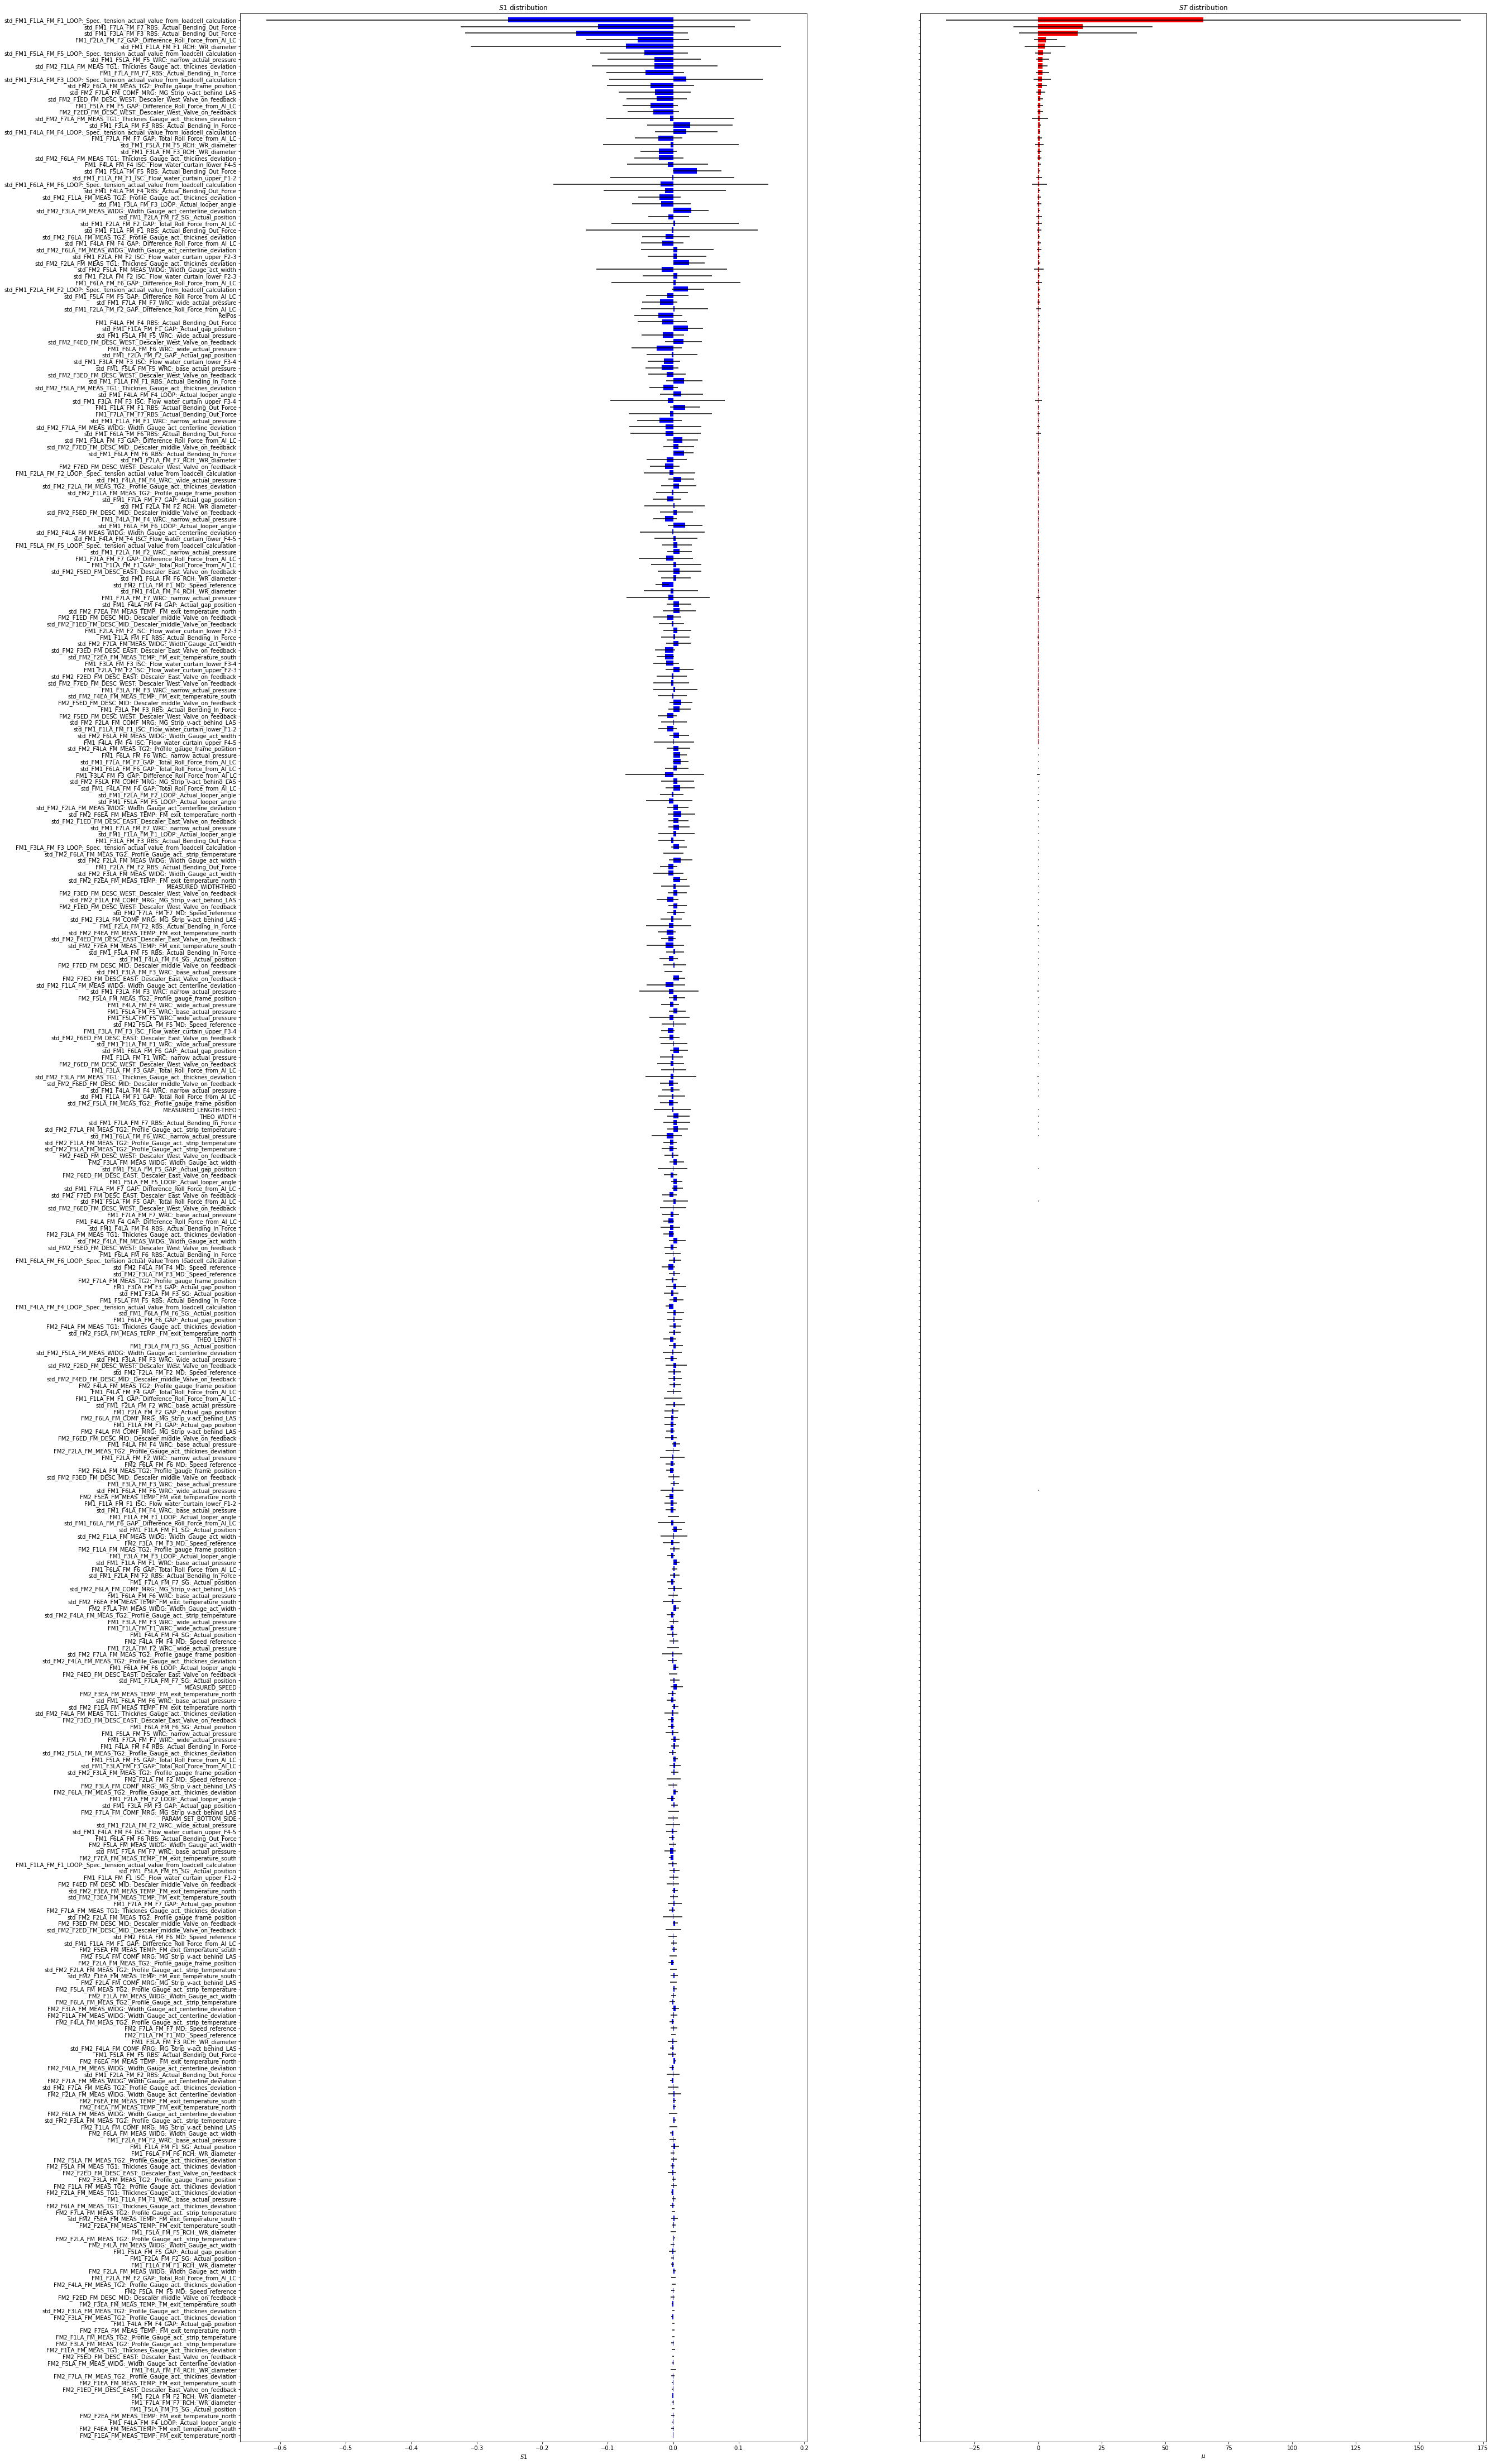

In [ ]:
# Plot horizontal barchart
y_pos = np.arange(len(names_sorted))
plot_names = names_sorted

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(40, 80), sharey=True)

ax1.barh(y_pos,
         s1_sorted,
         xerr=s1_conf_sorted,
         align='center',
         ecolor='black',
         color='blue')

ax2.barh(y_pos,
         st_sorted,
         xerr=st_conf_sorted,
         align='center',
         ecolor='black',
         color='red')

# plot S1 distribution
ax1.set_yticks(y_pos)
ax1.set_yticklabels(plot_names)
ax1.set_xlabel(r'$S1$')
ax1.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax1.set_title('$S1$ distribution')

# plot ST distribution
ax2.set_xlabel(r'$\mu$')
ax2.set_ylim(min(y_pos)-1, max(y_pos)+1)
ax2.set_title('$ST$ distribution')

plt.show()

In [ ]:
def drawgraphs(SAresults):
    # Get list of parameters
    parameters = list(SAresults['S1'].keys())
    # Set min index value, for the effects to be considered significant
    index_significance_value = 0.01
    
    '''
    Define some general layout settings.
    '''
    node_size_min = 15 # Max and min node size
    node_size_max = 30
    border_size_min = 1 # Max and min node border thickness
    border_size_max = 8
    edge_width_min = 1 # Max and min edge thickness
    edge_width_max = 10
    edge_distance_min = 0.1 # Max and min distance of the edge from the center of the circle
    edge_distance_max = 0.6 # Only applicable to the curved edges
    
    '''
    Set up some variables and functions that will facilitate drawing circles and 
    moving items around.
    '''
    # Define circle center and radius
    center = [0.0,0.0] 
    radius = 1.0
    
    # Function to get distance between two points
    def distance(p1,p2):
        return np.sqrt(((p1-p2)**2).sum())
    
    # Function to get middle point between two points
    def middle(p1,p2):
        return (p1+p2)/2
    
    # Function to get the vertex of a curve between two points
    def vertex(p1,p2,c):
        m = middle(p1,p2)
        curve_direction = c-m
        return m+curve_direction*(edge_distance_min+edge_distance_max*(1-distance(m,c)/distance(c,p1)))
    
    # Function to get the angle of the node from the center of the circle
    def angle(p,c):
        # Get x and y distance of point from center
        [dx,dy] = p-c 
        if dx == 0: # If point on vertical axis (same x as center)
            if dy>0: # If point is on positive vertical axis
                return np.pi/2.
            else: # If point is on negative vertical axis
                return np.pi*3./2.
        elif dx>0: # If point in the right quadrants
            if dy>=0: # If point in the top right quadrant
                return np.arctan(dy/dx)
            else: # If point in the bottom right quadrant
                return 2*np.pi+np.arctan(dy/dx)
        elif dx<0: # If point in the left quadrants
            return np.pi+np.arctan(dy/dx)
    
    '''
    First, set up graph with all parameters as nodes and draw all second order (S2)
    indices as edges in the network. For every S2 index, we need a Source parameter,
    a Target parameter, and the Weight of the line, given by the S2 index itself. 
    '''
    combs = [list(c) for c in list(itertools.combinations(parameters, 2))]
    
    Sources = list(list(zip(*combs))[0])
    Targets = list(list(zip(*combs))[1])
    # Sometimes computing errors produce negative Sobol indices. The following reads
    # in all the indices and also ensures they are between 0 and 1.
    Weights = [max(min(x, 1), 0) for x in [SAresults['S2'][Sources[i]][Targets[i]] for i in range(len(Sources))]]
    Weights = [0 if x < index_significance_value else x for x in Weights]
    
    # Set up graph
    G = nx.Graph()
    # Draw edges with appropriate weight
    for s,t,weight in zip(Sources, Targets, Weights):
        G.add_edges_from([(s,t)], w=weight)
    
    # Generate dictionary of node postions in a circular layout
    Pos = nx.circular_layout(G)
    
    '''
    Normalize node size according to first order (S1) index. First, read in S1 indices,
    ensure they're between 0 and 1 and normalize them within the max and min range
    of node sizes.
    Then, normalize edge thickness according to S2. 
    '''
    # Node size
    first_order = [max(min(x, 1), 0) for x in [SAresults['S1'][key] for key in SAresults['S1']]]
    first_order = [0 if x<index_significance_value else x for x in first_order]
    node_size = [node_size_min*(1 + (node_size_max-node_size_min)*k/max(first_order)) for k in first_order]
    # Node border thickness
    total_order = [max(min(x, 1), 0) for x in [SAresults['ST'][key] for key in SAresults['ST']]]
    total_order = [0 if x<index_significance_value else x for x in total_order]
    border_size = [border_size_min*(1 + (border_size_max-border_size_min)*k/max(total_order)) for k in total_order]
    # Edge thickness
    edge_width = [edge_width_min*((edge_width_max-edge_width_min)*k/max(Weights)) for k in Weights]
    
    '''
    Draw network. This will draw the graph with straight lines along the edges and 
    across the circle. 
    '''    
    # nx.draw_networkx_nodes(G, Pos, node_size=node_size, node_color='#98B5E2', 
    #                        edgecolors='#1A3F7A', linewidths = border_size)
    # nx.draw_networkx_edges(G, Pos, width=edge_width, edge_color='#2E5591', alpha=0.7)
    # names = nx.draw_networkx_labels(G, Pos, font_size=12, font_color='#0B2D61', font_family='sans-serif')
    # for node, text in names.items():
    #     position = (radius*1.1*np.cos(angle(Pos[node],center)), radius*1.1*np.sin(angle(Pos[node],center)))
    #     text.set_position(position)
    #     text.set_clip_on(False)
    # plt.gcf().set_size_inches(20, 20) # Make figure a square
    # plt.axis('off')
    
    '''
     We can now draw the network with curved lines along the edges and across the circle.
     Calculate all distances between 1 node and all the others (all distances are 
     the same since they're in a circle). We'll need this to identify the curves 
     we'll be drawing along the perimeter (i.e. those that are next to each other).
     '''
    min_distance = round(min([distance(Pos[list(G.nodes())[0]],Pos[n]) for n in list(G.nodes())[1:]]), 1)
    
    # Figure to generate the curved edges between two points
    def xy_edge(p1,p2): # Point 1, Point 2
        m = middle(p1,p2) # Get middle point between the two nodes
        # If the middle of the two points falls very close to the center, then the 
        # line between the two points is simply straight
        if distance(m,center)<1e-6:
            xpr = np.linspace(p1[0],p2[0],10)
            ypr = np.linspace(p1[1],p2[1],10)
        # If the distance between the two points is the minimum (i.e. they are next
        # to each other), draw the edge along the perimeter     
        elif distance(p1,p2)<=min_distance:
            # Get angles of two points
            p1_angle = angle(p1,center)
            p2_angle = angle(p2,center)
            # Check if the points are more than a hemisphere apart
            if max(p1_angle,p2_angle)-min(p1_angle,p2_angle) > np.pi:
                radi = np.linspace(max(p1_angle,p2_angle)-2*np.pi,min(p1_angle,p2_angle))
            else:
                radi = np.linspace(min(p1_angle,p2_angle),max(p1_angle,p2_angle))
            xpr = radius*np.cos(radi)+center[0]
            ypr = radius*np.sin(radi)+center[1]  
        # Otherwise, draw curve (parabola)
        else: 
            edge_vertex = vertex(p1,p2,center)
            a = distance(edge_vertex, m)/((distance(p1,p2)/2)**2)
            yp = np.linspace(-distance(p1,p2)/2, distance(p1,p2)/2,100)
            xp = a*(yp**2)
            xp += distance(center,edge_vertex)
            theta_m = angle(middle(p1,p2),center)
            xpr = np.cos(theta_m)*xp - np.sin(theta_m)*yp
            ypr = np.sin(theta_m)*xp + np.cos(theta_m)*yp
            xpr += center[0]
            ypr += center[1]
        return xpr,ypr
      
    '''
    Draw network. This will draw the graph with curved lines along the edges and 
    across the circle. 
    '''
    fig = plt.figure(figsize=(30, 25))
    ax = fig.add_subplot(1,1,1)
    for i, e in enumerate(G.edges()):
        x,y=xy_edge(Pos[e[0]],Pos[e[1]])
        ax.plot(x,y,'-',c='#2E5591',lw=edge_width[i],alpha=0.7)
    for i, n in enumerate(G.nodes()):
        ax.plot(Pos[n][0],Pos[n][1], 'o', c='#98B5E2', markersize=node_size[i]/5, markeredgecolor = '#1A3F7A', markeredgewidth = border_size[i]*1.15)
    
    for i, text in enumerate(G.nodes()):
        if node_size[i]<100:
            position = (radius*1.05*np.cos(angle(Pos[text],center)), radius*1.05*np.sin(angle(Pos[text],center)))
        else:
            position = (radius*1.01*np.cos(angle(Pos[text],center)), radius*1.01*np.sin(angle(Pos[text],center)))
        plt.annotate(text, position, fontsize = 12, color='#0B2D61', family='sans-serif')          
    ax.axis('off')
    ax.set_title('Cord graph for parameters with top {} $ST$ values'.format(len(SAresults['S1'].keys())))
    fig.tight_layout()
    plt.show()

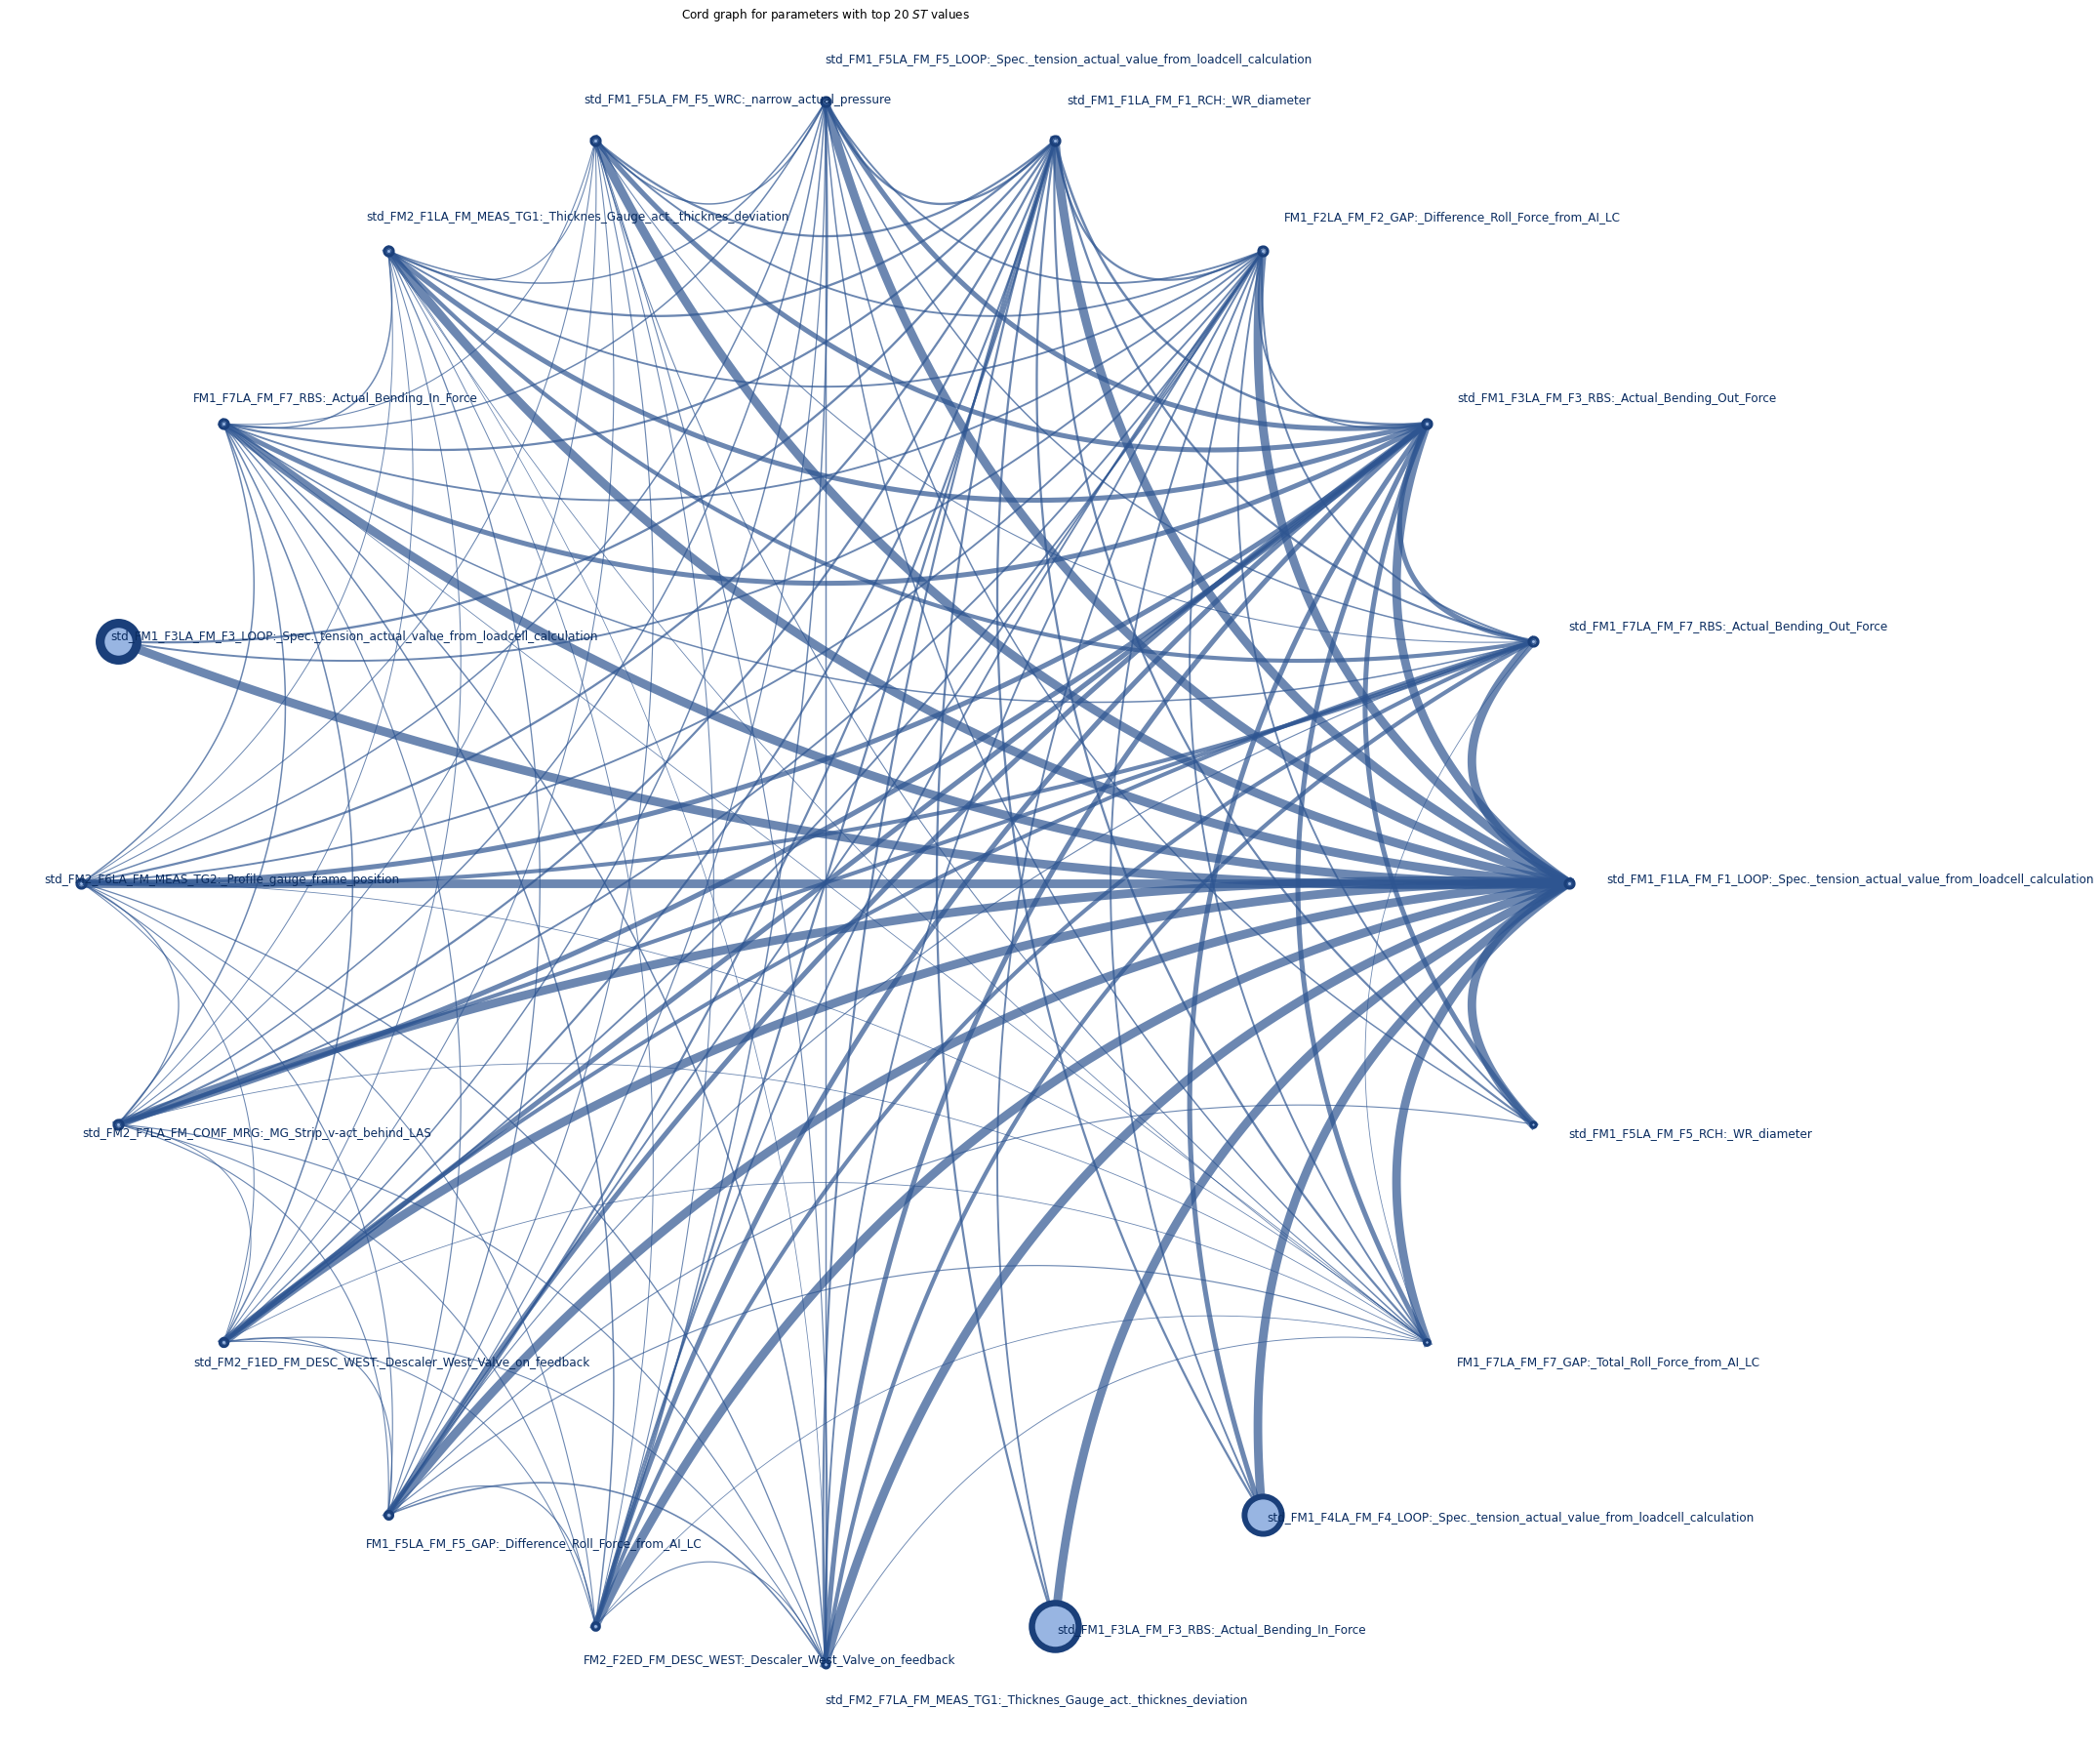

In [ ]:
def nan_to_zero(si_result):
    for k in si_result.keys():
        si_result[k] = np.nan_to_num(si_result[k])
    return si_result

def S2_to_dict(matrix, problem):
    result = {}
    names = list(problem["names"])
    
    for i in range(problem["num_vars"]):
        for j in range(i+1, problem["num_vars"]):
            if names[i] not in result:
                result[names[i]] = {}
            if names[j] not in result:
                result[names[j]] = {}
            result[names[i]][names[j]] = result[names[j]][names[i]] = float(matrix[i][j])
    return result

def sort_result(result, on='ST', n=30):
    sorted_result = {'S1': {}, 'S1_conf': {}, 'ST': {}, 'ST_conf': {}, 'S2': {}, 'S2_conf': {}}
    if on == 'S2':
        sorted_result = {}
    else:
        sort_keys = [i for i, _ in sorted(result[on].items(), key=lambda x: x[1], reverse=True)]
        topn = sort_keys[:n]
        for k in topn:
            sorted_result['S1'][k] = result['S1'][k]
            sorted_result['S1_conf'][k] = result['S1_conf'][k]
            sorted_result['ST'][k] = result['ST'][k]
            sorted_result['ST_conf'][k] = result['ST_conf'][k]
        for i in topn:
            sorted_result['S2'][i] = {}
            sorted_result['S2_conf'][i] = {}
            for j in topn:
                if i != j:
                    sorted_result['S2'][i][j] = result['S2'][i][j]
                    sorted_result['S2_conf'][i][j] = result['S2_conf'][i][j]
    return sorted_result


# convert nan values to zeros
si_sobol = nan_to_zero(si_sobol)

result = {} #create dictionary to store new
result['S1'] = {k : float(v) for k, v in zip(problem["names"], si_sobol["S1"])}
result['S1_conf'] = {k : float(v) for k, v in zip(problem["names"], si_sobol["S1_conf"])}
result['S2'] = S2_to_dict(si_sobol['S2'], problem)
result['S2_conf'] = S2_to_dict(si_sobol['S2_conf'], problem)
result['ST']={k : float(v) for k, v in zip(problem["names"], si_sobol["ST"])}
result['ST_conf']={k : float(v) for k, v in zip(problem["names"], si_sobol["ST_conf"])}

# plot cord graph of parameters with top 30 ST values
sort_result = sort_result(result, on='ST', n=20)

drawgraphs(sort_result)

The above graph displays the results of a Sobol analysis for parameters with top 20 $ST$ values. The node size indicates the first order index $
S1$ per parameter, the node border thickness indicates the total order index $ST$ per parameter, and the thickness of the line between two nodes indicates the secord order index $S2$.

After loading the necessary packages (networkx, numpy, itertools, and matplotlib) and data, there is some setting parameters that can be adapted for the figure generation. First, we can define a significance value for the indices (here set to 0.01). To keep all values just set it to 0. Then we have some stylistic variables that basically define the thicknesses and sizes for the lines and nodes. They can be changed to get the look of the graph to your liking.